# For sanity checking output of diurnal analysis results

In [112]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
from sys import getsizeof

import diurnal_config

# from diurnal_utils import *
%run diurnal_utils.py
%run model_by_model_analysis_helper.py
from fetch_model_helper import *

FLUX_TO_MM_HR = 60*60
MM_HR_TO_MM_DAY = 24.0
MM_HR_TO_MM_YR = 24*365
FLUX_TO_MM_YR = FLUX_TO_MM_HR*MM_HR_TO_MM_YR
FLUX_TO_MM_DAY = FLUX_TO_MM_HR*MM_HR_TO_MM_DAY

In [113]:
gpm_full_path = '/export/data1/cchristo/diurnal_analysis_results/GPM_bin_pt5_hr_15_yr_round_2_mode_ensemble_final/2000-06_2016-06_precip.nc'

ds_gpm_2 = xr.open_dataset(gpm_full_path)

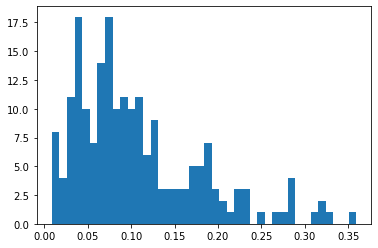

In [114]:
_ = plt.hist(ds_gpm_2.sel(lat = 5, lon = 130, method = 'nearest')['ampl_season'].values, bins = 40)

In [115]:
ds_gpm_2_mean = ds_gpm_2.mean(dim = 'bootstrap_id')
# ds_gpm_2_mode = ds_gpm_2.mode(dim = 'bootstrap_id')
ds_gpm_std = ds_gpm_2.std(dim = 'bootstrap_id')['ampl_season']

In [133]:
ds_gpm_quart_low = ds_gpm_2['ampl_season'].quantile(0.4)

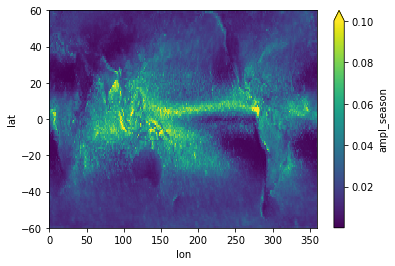

In [116]:
ds_gpm_std.plot(vmax = 0.1)

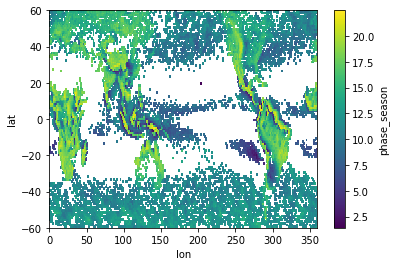

In [144]:
ds_gpm_2_mean.where(ds_gpm_2_mean['ampl_season'] - 1.8*ds_gpm_std > 0)['phase_season'].plot()

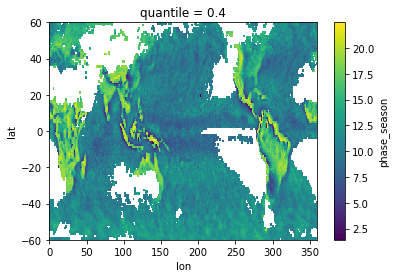

In [134]:
ds_gpm_2_mean.where(ds_gpm_2_mean['ampl_season'] - ds_gpm_quart_low > 0)['phase_season'].plot()

$e^{i\pi} + 1 = 0$

In [140]:
rel_data_dir = '/export/data1/cchristo/'

# raw output
input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/' #GFDL-ESM2M/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_bin_pt2_hr_round_closest_gpm_overlap_2_modes/' #GFDL-ESM4/'
input_data_dir_gpm = rel_data_dir + 'diurnal_analysis_results/GPM_bin_pt2_hr_15_yr_round/'
# regridded data
input_data_dir_cm5_regridded = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm6_regridded  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'


# cmip6_fname = '1985-01_2015-01_precip.nc'
cmip6_fname = '1985-01_2015-01_precip.nc'
cmip5_fname = '1976-01_2006-01_precip.nc'

mean_pr_dir = '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/pr_3hr/'

In [136]:
rel_data_dir = '/export/data1/cchristo/'
# get all available model names
rel_cmip6_path= '/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'
unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [6]:
input_data_dir_cm6

'/export/data1/cchristo/diurnal_analysis_results/CMIP6_bin_pt2_hr_round/'

## Compute yearly means

In [21]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = '1985-01_2015-01_precip.nc',
                               compute_year_mean_bool = True,
                               verbose = True)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = '1976-01_2006-01_precip.nc', 
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

df = df_models.copy()
# merge land/sea mask
# df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# # df = df.reset_index('season')
# df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 1min 3s, sys: 0 ns, total: 1min 3s
Wall time: 1min 6s


In [50]:
### CMIP
model_name = "IPSL-CM6A-LR"
ds_i = xr.open_dataset(input_data_dir_cm6 + model_name + '/' + '1985-01_2006-01_precip.nc')
### GPM

ds_i_gpm = xr.open_dataset(input_data_dir_gpm + '2000-06_2016-06_precip.nc')

<xarray.Dataset>
Dimensions:           (lat: 120, lon: 288)
Coordinates:
  * lat               (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 57.5 58.5 59.5
  * lon               (lon) float64 0.625 1.875 3.125 ... 356.9 358.1 359.4
Data variables:
    mu_season         (lat, lon) float64 2.258e-05 2.255e-05 ... 2.841e-05
    sigma_season      (lat, lon) float64 1.257e-06 1.24e-06 ... 2.004e-06
    ampl_season       (lat, lon) float64 1.53e-06 1.491e-06 ... 2.222e-06
    phase_season      (lat, lon) float64 4.407 4.55 5.192 ... 2.87 3.048 3.272
    ampl_cov_season   (lat, lon) float64 3.06e-15 3.524e-15 ... 1.878e-14
    phase_cov_season  (lat, lon) float64 0.02683 0.02632 ... 0.03641 0.06734
    model_name        (lat, lon) object 'GFDL-CM4' 'GFDL-CM4' ... 'GFDL-CM4'
    cmip_identifier   (lat, lon) object 'CMIP6' 'CMIP6' ... 'CMIP6' 'CMIP6'

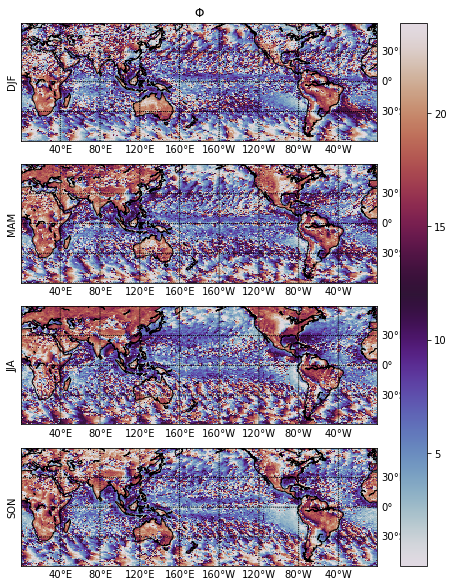

In [51]:
# ds_i_gpm
make_four_panel(ds_i_gpm['phase_season'])

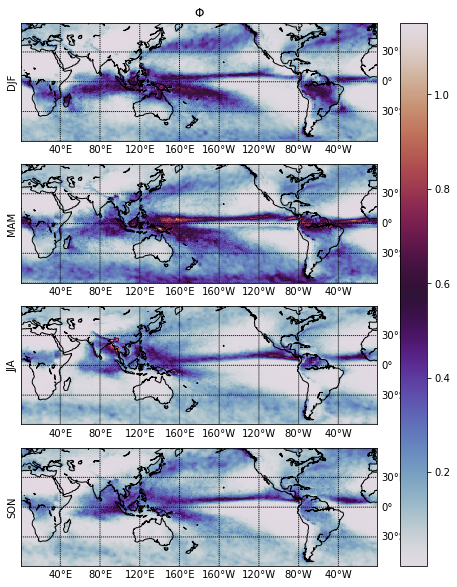

In [59]:
make_four_panel(ds_i_gpm['mu_season'])

In [16]:
# ds_i.input_dataset_paths
len(unique_cmip6_models)

28

In [6]:
print('lat, lon spacing', 
      np.median(np.diff(ds_i.lat)),
      np.median(np.diff(ds_i.lon)))

lat, lon spacing 1.2676048 2.5


In [7]:
ds_i

<xarray.Dataset>
Dimensions:           (lat: 95, lon: 144, season: 4)
Coordinates:
  * season            (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon               (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat               (lat) float32 -59.577465 -58.30986 ... 58.30986 59.577465
Data variables:
    mu_season         (season, lat, lon) float64 ...
    sigma_season      (season, lat, lon) float64 ...
    ampl_season       (season, lat, lon) float64 ...
    phase_season      (season, lat, lon) float64 ...
    ampl_cov_season   (season, lat, lon) float64 ...
    phase_cov_season  (season, lat, lon) float64 ...
Attributes:
    input_dataset_paths:  /export/data1/cchristo/CMIP6_precip/pr_3hr_historic...

In [26]:
ds_i

<xarray.Dataset>
Dimensions:           (lat: 60, lon: 180, season: 4)
Coordinates:
  * season            (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon               (lon) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat               (lat) float64 -59.75 -57.72 -55.7 ... 55.7 57.72 59.75
Data variables:
    mu_season         (season, lat, lon) float64 2.101e-05 ... 3.981e-05
    sigma_season      (season, lat, lon) float64 ...
    ampl_season       (season, lat, lon) float64 ...
    phase_season      (season, lat, lon) float64 ...
    ampl_cov_season   (season, lat, lon) float64 ...
    phase_cov_season  (season, lat, lon) float64 ...
Attributes:
    input_dataset_paths:  ['/export/data1/cchristo/CMIP6_precip/pr_3hr_histor...

GISS-E2-H
lat, lon spacing 2.0 2.5


<Figure size 864x504 with 0 Axes>

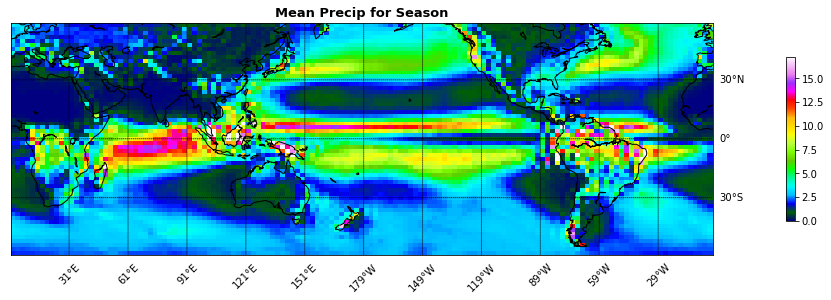

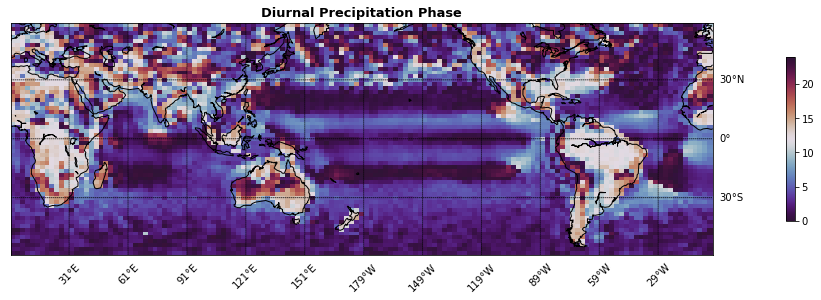

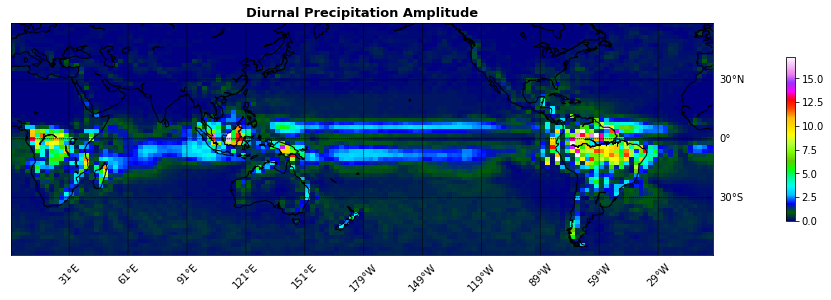

FGOALS-g2
lat, lon spacing 2.790586471557617 2.8125


<Figure size 864x504 with 0 Axes>

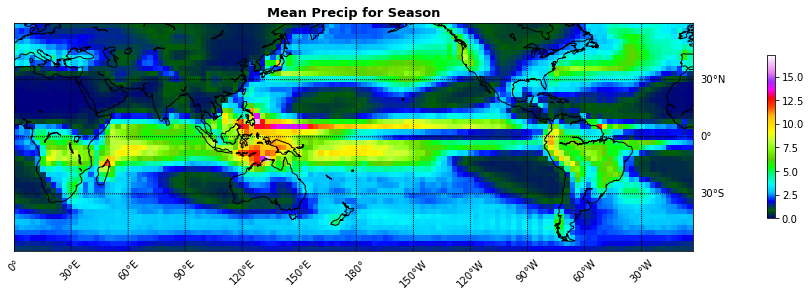

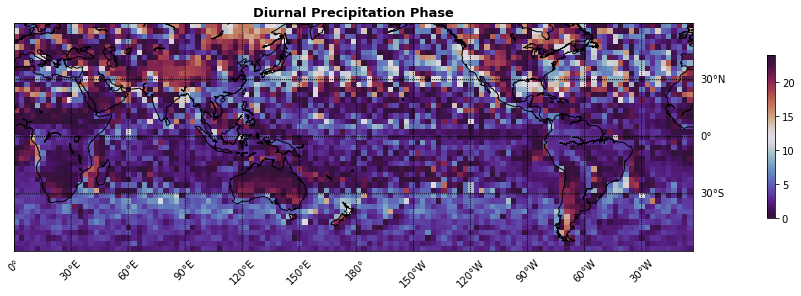

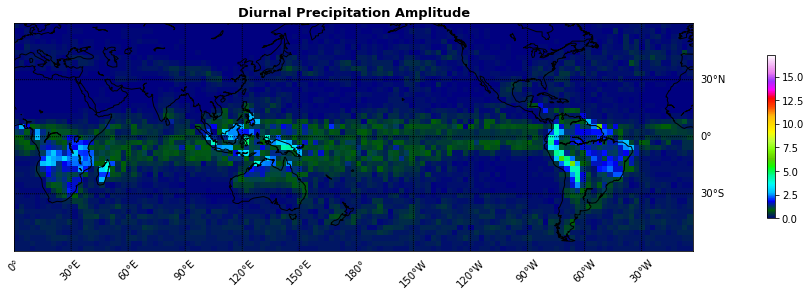

MIROC-ESM-CHEM
lat, lon spacing 2.790584259981273 2.8125


<Figure size 864x504 with 0 Axes>

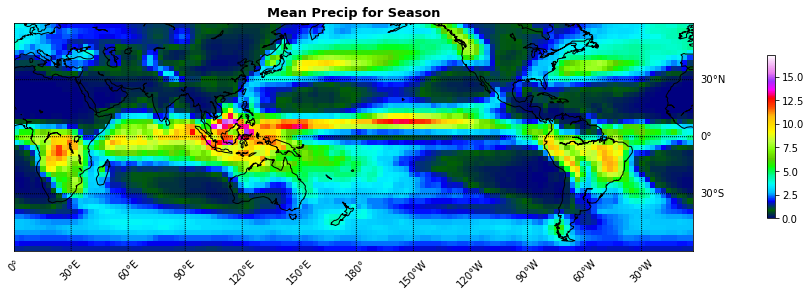

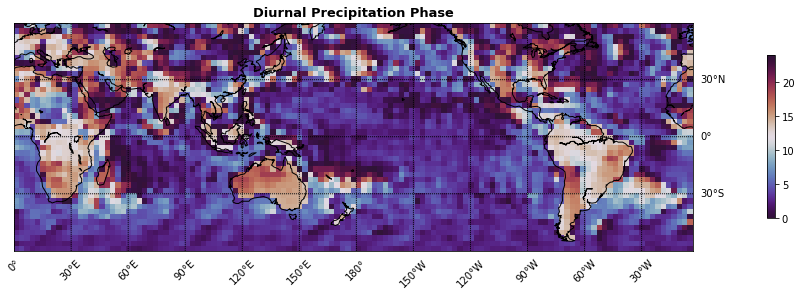

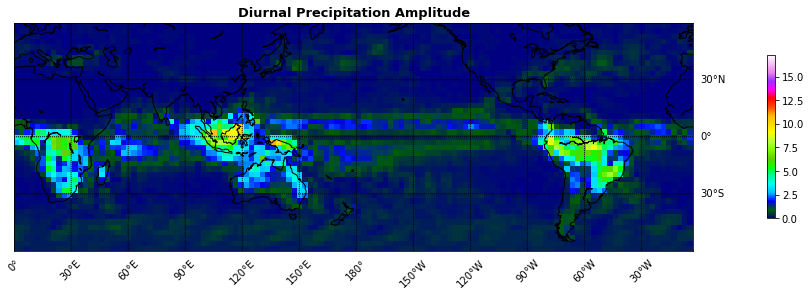

FGOALS-s2
lat, lon spacing 1.6589622497558594 2.8125


<Figure size 864x504 with 0 Axes>

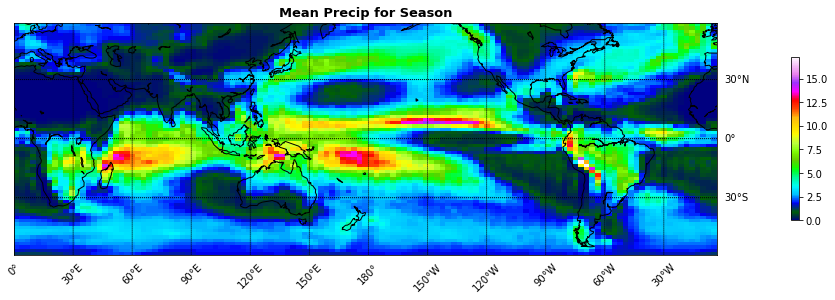

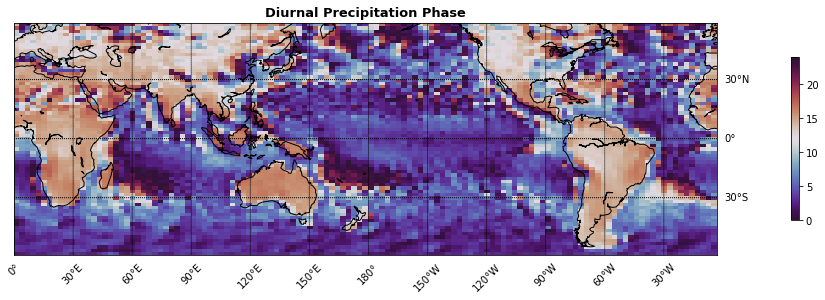

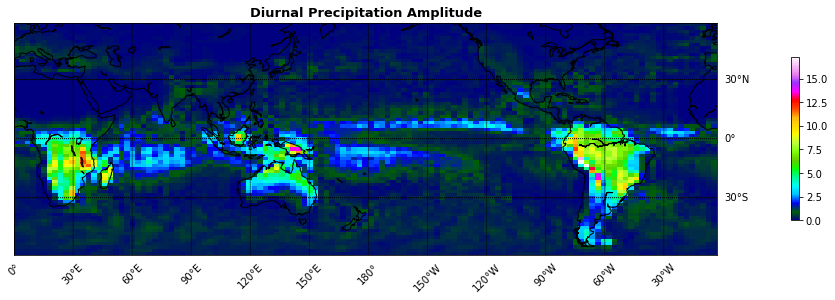

GFDL-CM3
lat, lon spacing 2.0 2.5


<Figure size 864x504 with 0 Axes>

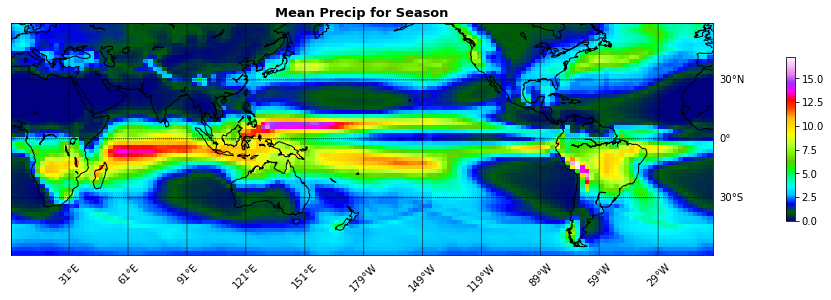

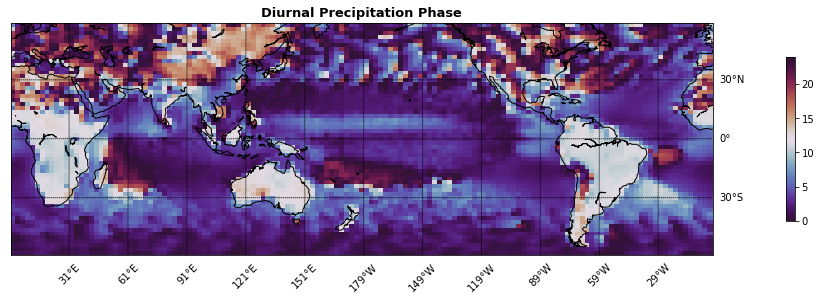

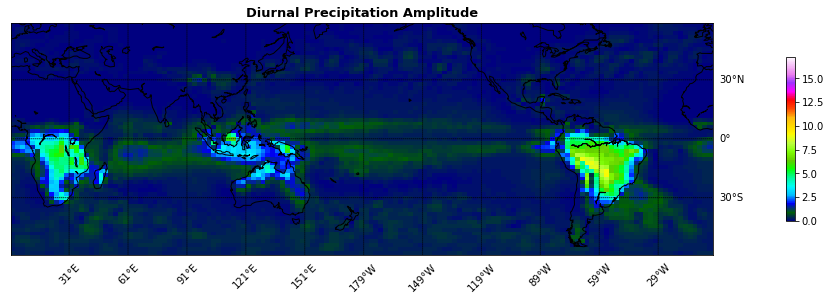

MIROC4h
Could not open:  MIROC4h  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/MIROC4h/1976-01_2006-01_precip.nc'
NorESM1-M
Could not open:  NorESM1-M  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/NorESM1-M/1976-01_2006-01_precip.nc'
MIROC5
lat, lon spacing 1.4007642344911346 1.40625


<Figure size 864x504 with 0 Axes>

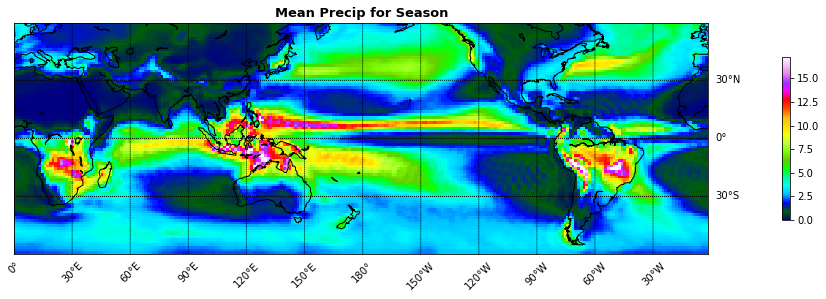

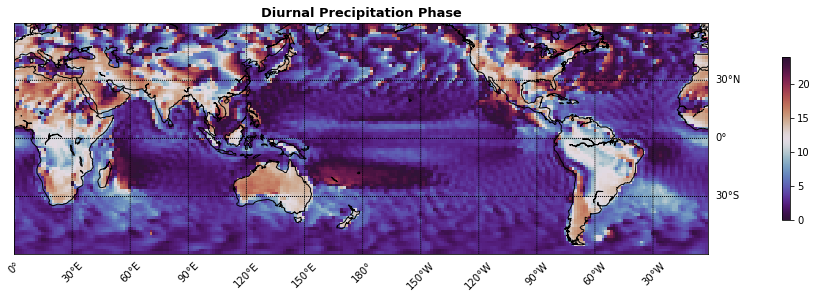

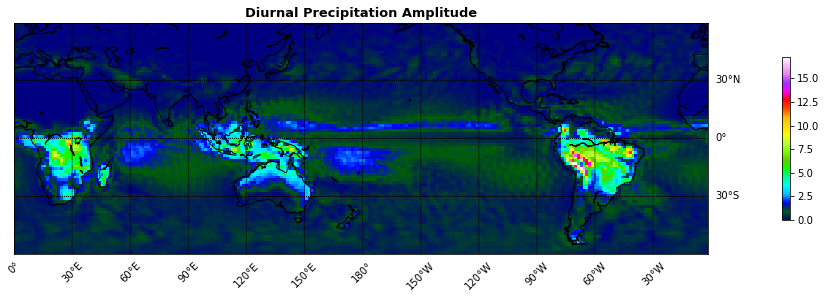

CNRM-CM5
lat, lon spacing 1.4007644653320312 1.40625


<Figure size 864x504 with 0 Axes>

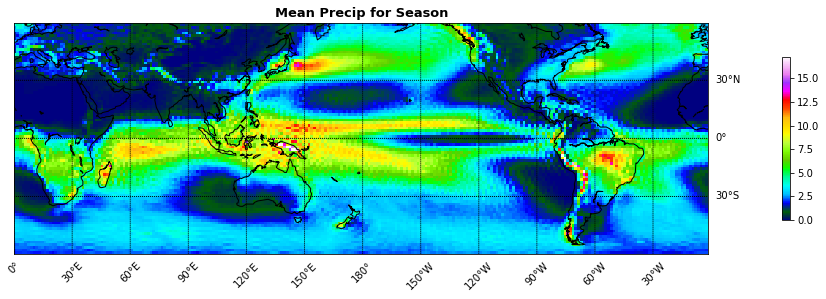

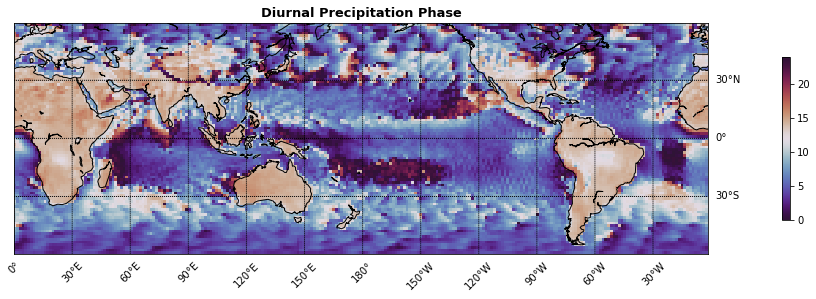

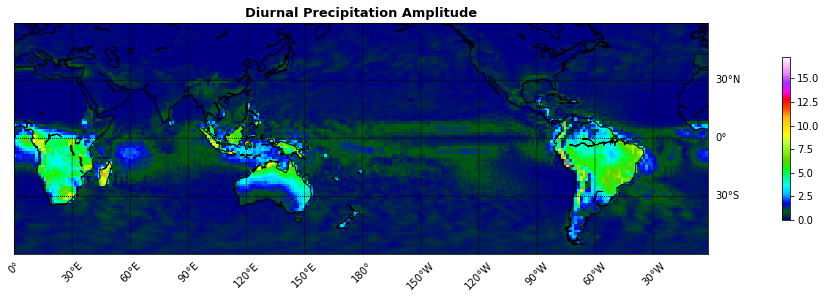

GISS-E2-R
lat, lon spacing 2.0 2.5


<Figure size 864x504 with 0 Axes>

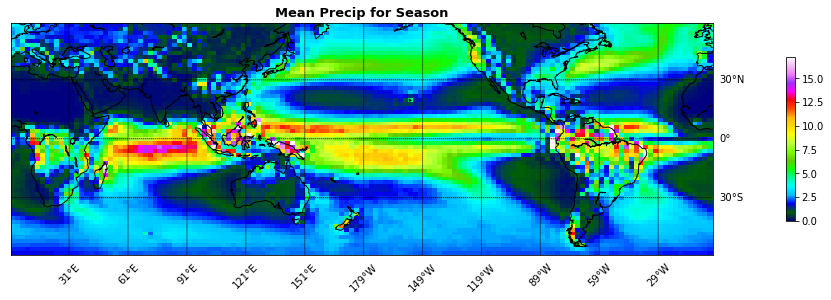

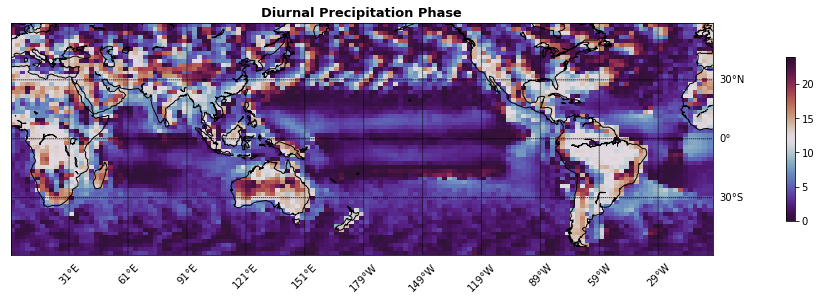

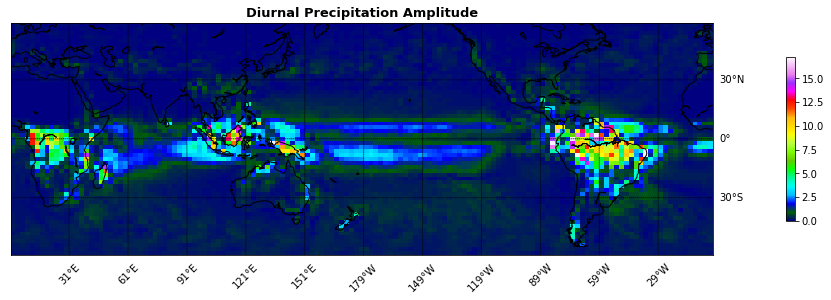

IPSL-CM5A-LR
lat, lon spacing 1.8947372436523438 3.75


<Figure size 864x504 with 0 Axes>

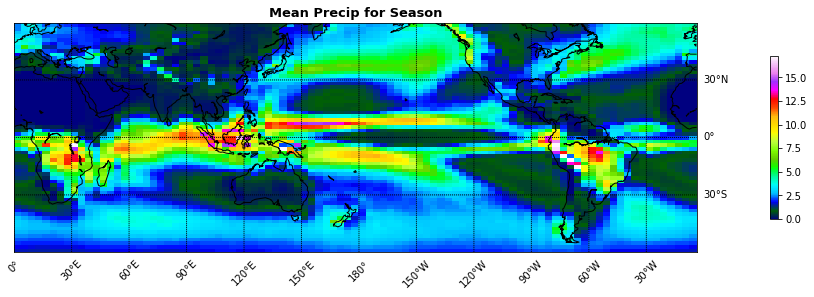

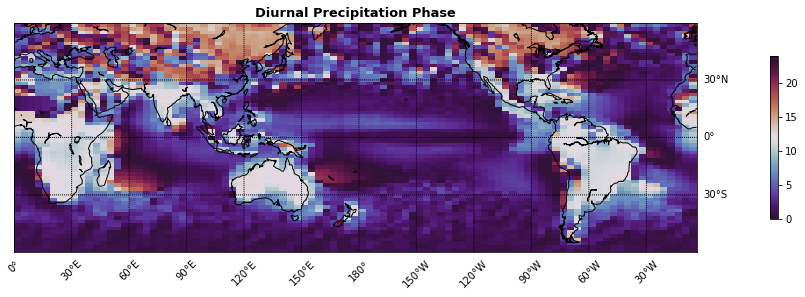

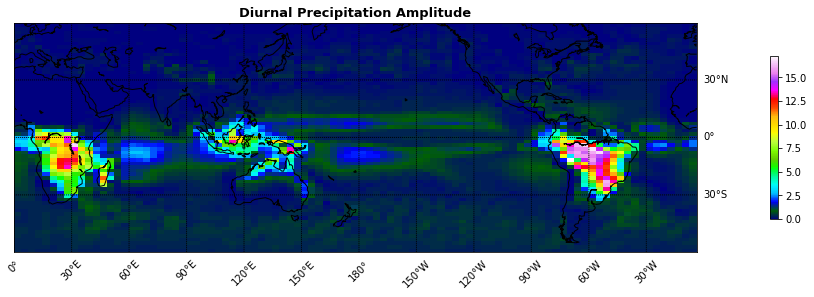

MIROC-ESM
lat, lon spacing 2.790584259981273 2.8125


<Figure size 864x504 with 0 Axes>

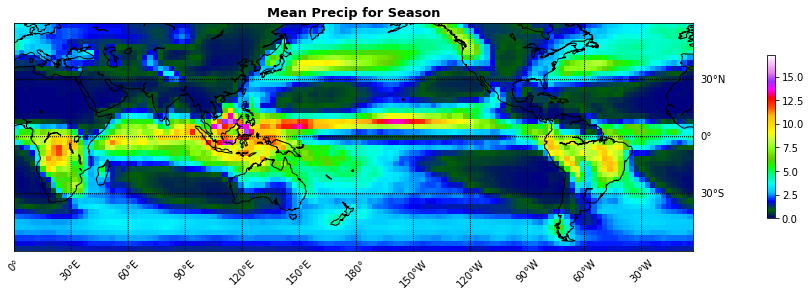

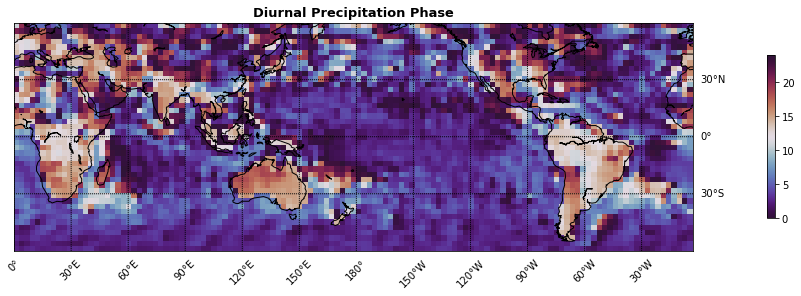

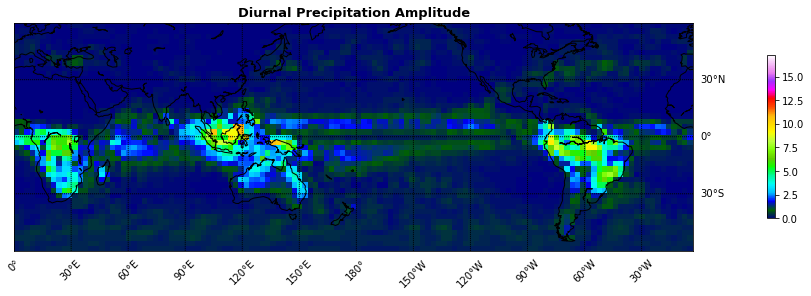

HadGEM2-ES
Could not open:  HadGEM2-ES  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/HadGEM2-ES/1976-01_2006-01_precip.nc'
GFDL-ESM2M
lat, lon spacing 2.0224719101123583 2.5


<Figure size 864x504 with 0 Axes>

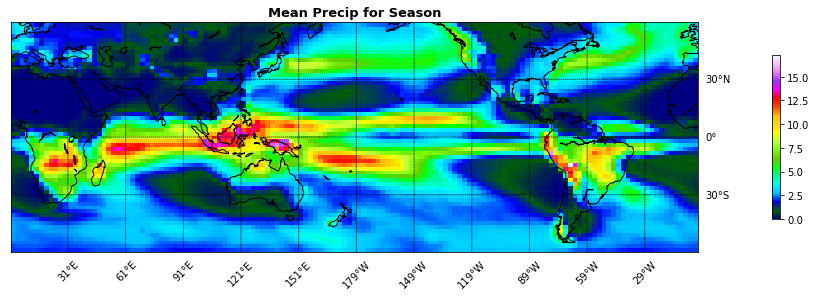

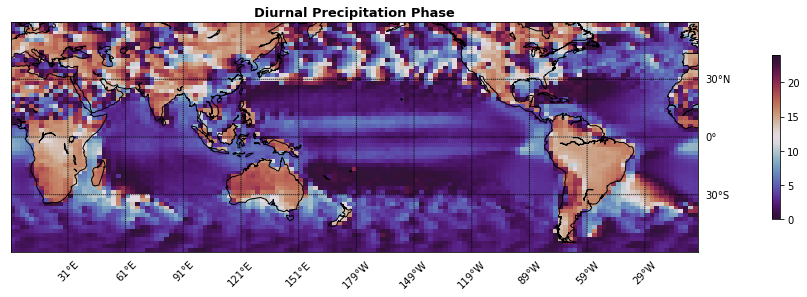

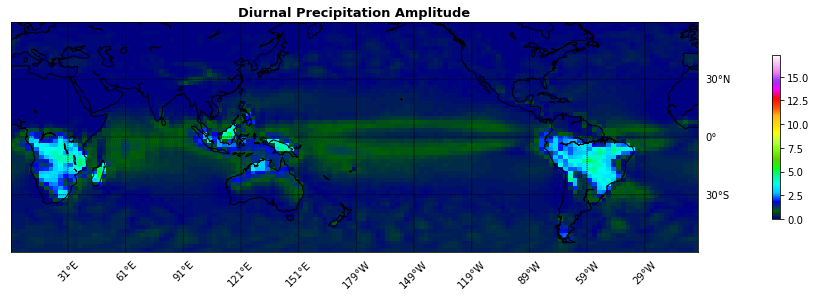

inmcm4
Could not open:  inmcm4  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/inmcm4/1976-01_2006-01_precip.nc'
GFDL-ESM2G
Could not open:  GFDL-ESM2G  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/GFDL-ESM2G/1976-01_2006-01_precip.nc'
CMCC-CM
Could not open:  CMCC-CM  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/CMCC-CM/1976-01_2006-01_precip.nc'
MRI-ESM1
lat, lon spacing 1.1214899999999997 1.125


<Figure size 864x504 with 0 Axes>

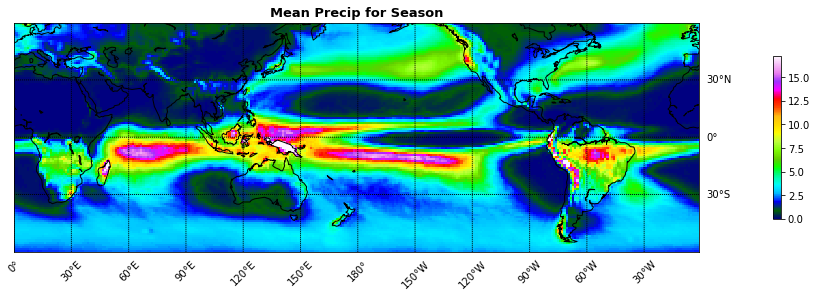

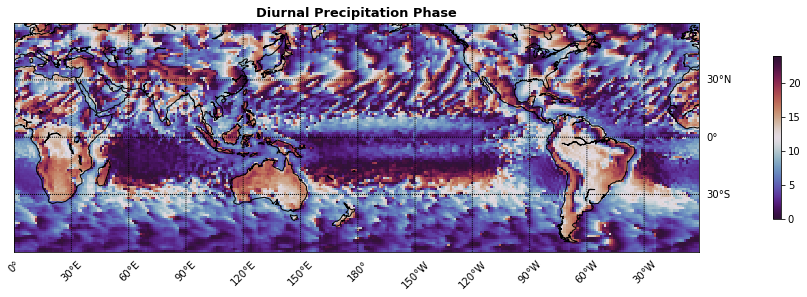

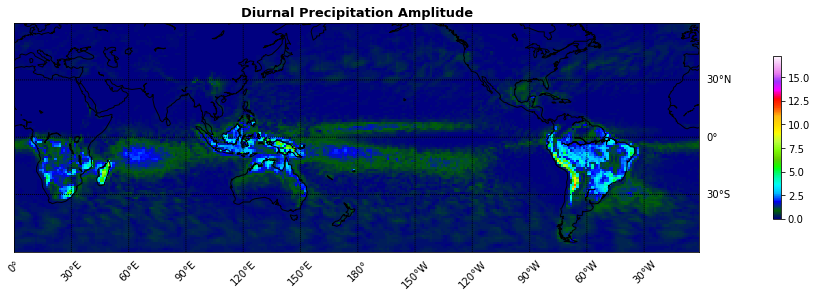

IPSL-CM5A-MR
Could not open:  IPSL-CM5A-MR  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/IPSL-CM5A-MR/1976-01_2006-01_precip.nc'
ACCESS1-0
Could not open:  ACCESS1-0  :  [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP5_bin_pt1_hr_round_closest_gpm_overlap_2_modes/ACCESS1-0/1976-01_2006-01_precip.nc'
ACCESS1-3
lat, lon spacing 1.25 1.875


<Figure size 864x504 with 0 Axes>

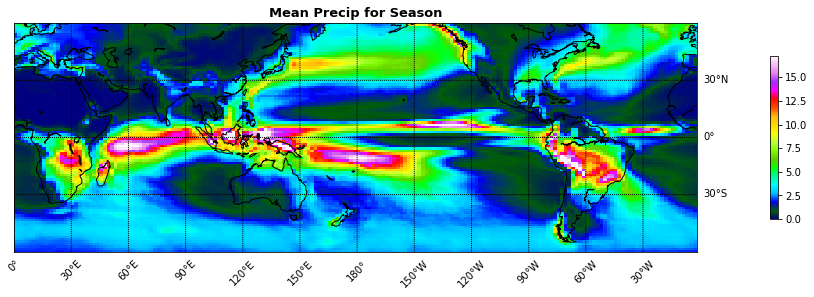

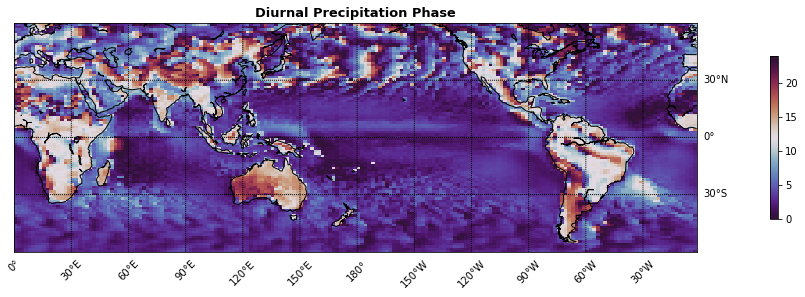

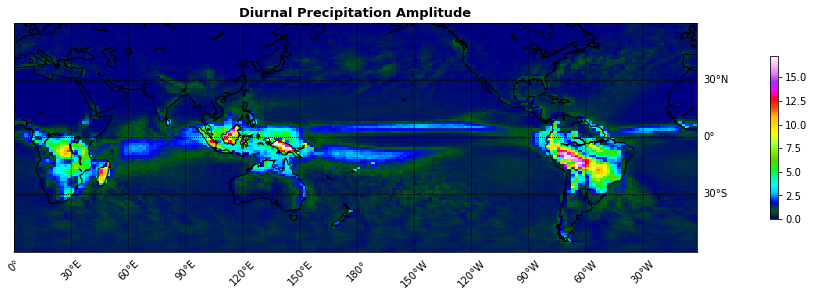

MRI-CGCM3
lat, lon spacing 1.1214899999999997 1.125


<Figure size 864x504 with 0 Axes>

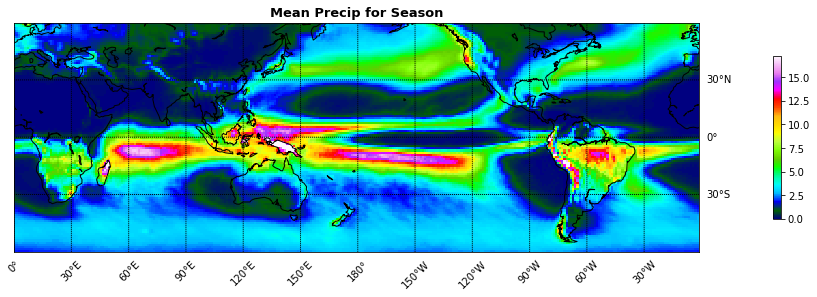

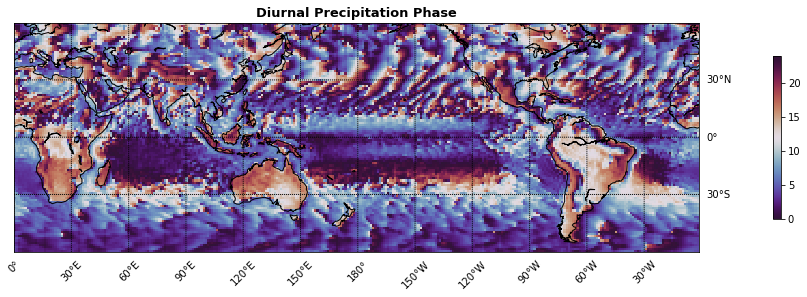

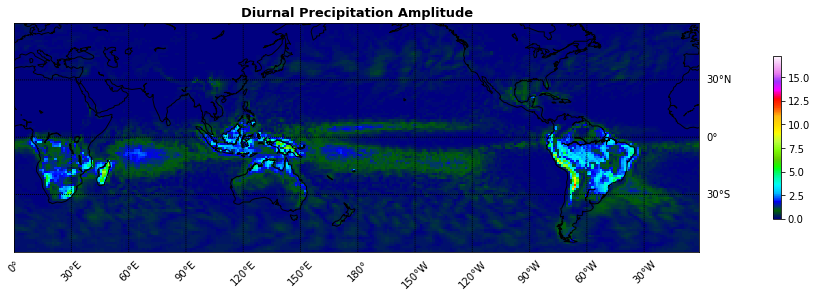

In [141]:
season_i = 0
for model_name in list(unique_cmip5_models): 
# for model_name in [model_name]:
    print(model_name)
    try:
        ds_i = xr.open_dataset(input_data_dir_cm5 + model_name + '/' + cmip5_fname)
        # use means
#         ds_i = xr.Dataset.from_dataframe(df[df['model_name'] == model_name])
        

    
#         ds_pr_mean = xr.open_dataset(mean_pr_dir + model_name + '/' + '1985-01_2006-01_mean.nc')
#         ds_pr_mean['pr'] = ds_pr_mean['pr']*FLUX_TO_MM_DAY

        print('lat, lon spacing', 
              np.median(np.diff(ds_i.lat)),
              np.median(np.diff(ds_i.lon)))
    #     print(ds_i.input_dataset_paths)
    #     print(ds_i.input_dataset_paths)
        plt.figure(figsize = (12,7))
    #     print(ds_i.isel(season = season_i).season.item())
        ds_i_season_mu = ds_i['mu_season'].isel(season = season_i)
        ds_i_season_phase = ds_i['phase_season'].isel(season = season_i)
        ds_i_season_ampl = ds_i['ampl_season'].isel(season = season_i)
        # ds_i['phase_season'].isel(season = season_i).plot.hist(bins = 50)
#         ds_i_sigma = ds_i[['phase_cov_season', 'ampl_cov_season']].apply(np.sqrt)




        make_single_plot(ds_i_season_mu*FLUX_TO_MM_DAY, 
                         title = r'Mean Precip for Season',
                         cmap = plt.get_cmap('gist_ncar'),
                         vmin = 0, vmax = 0.0002*FLUX_TO_MM_DAY)


#         make_single_plot(ds_pr_mean['pr'].where(ds_pr_mean['pr'] < 0.5), 
#                          title = r'Mean Precip where',
#                          cmap = plt.get_cmap('gist_ncar'),
#                          vmin = 0, vmax = 0.0002*FLUX_TO_MM_DAY)

        make_single_plot(ds_i_season_phase, 
                         title = r'Diurnal Precipitation Phase',
                         cmap = plt.get_cmap('twilight_shifted'),
                         vmin = 0, vmax = 24)
#         make_single_plot(ds_i_sigma['phase_cov_season'], 
#                          title = r'Diurnal Precipitation Phase Cov',
#                          cmap = plt.get_cmap('Reds'),
#                          vmin = 0, vmax = 1.5)

        make_single_plot(ds_i_season_ampl*FLUX_TO_MM_DAY, 
                         title = r'Diurnal Precipitation Amplitude',
                         cmap = plt.get_cmap('gist_ncar'),
                         vmin = 0, vmax = 0.0002*FLUX_TO_MM_DAY)
        plt.show()

    
    except Exception as e:
        print('Could not open: ', model_name, ' : ', e)
# abs_ampl = ds_i_season_ampl.to_dataset().apply(np.abs)['ampl_season']
# rel_error_ampl = (ds_i_sigma.isel(season = season_i)['ampl_cov_season']/abs_ampl)

# make_single_plot(rel_error_ampl, 
#                  title = r'Diurnal Precipitation Amplitude Cov',
#                  cmap = plt.get_cmap('Reds'),
#                  vmin = 0, vmax = 0.2)

UKESM1-0-LL


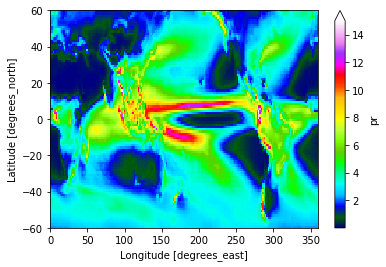

BCC-CSM2-MR


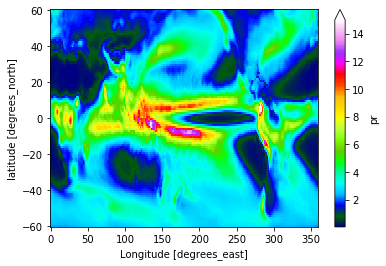

KACE-1-0-G


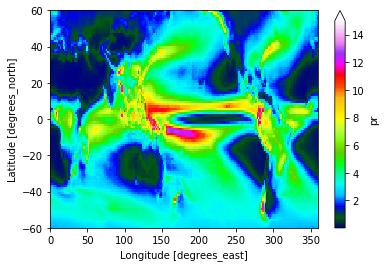

MPI-ESM-1-2-HAM


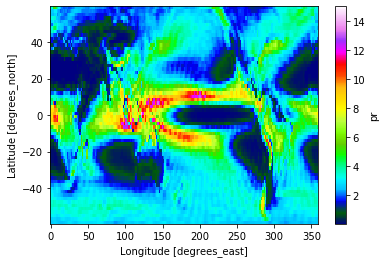

ACCESS-ESM1-5


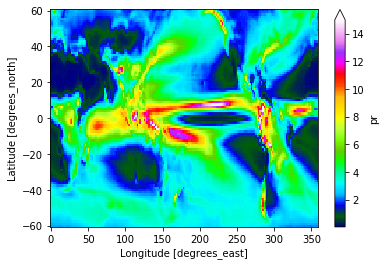

EC-Earth3-Veg


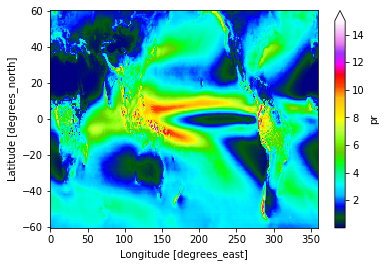

MRI-ESM2-0


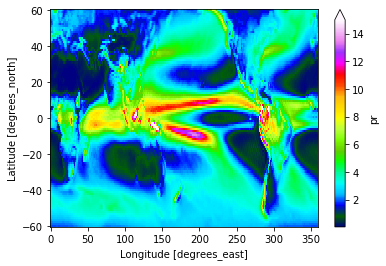

EC-Earth3


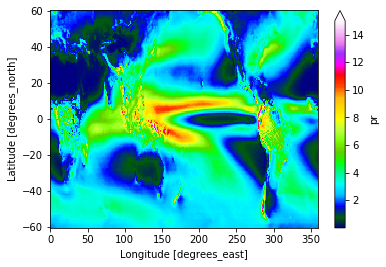

SAM0-UNICON


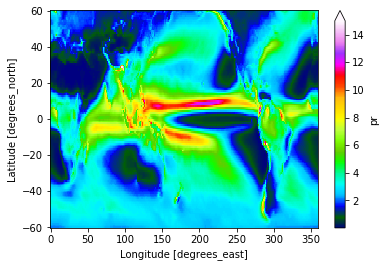

CanESM5


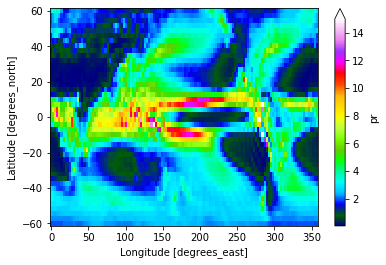

ACCESS-CM2


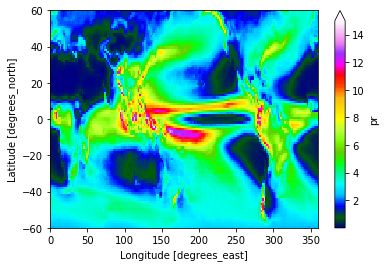

CNRM-CM6-1


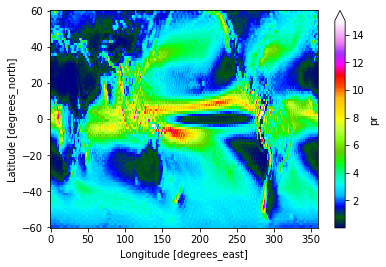

GISS-E2-1-G


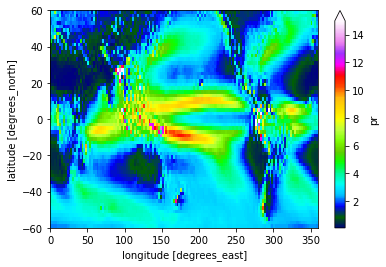

EC-Earth3-Veg-LR


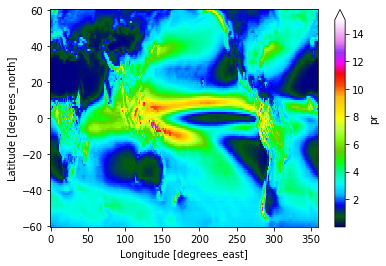

CNRM-CM6-1-HR


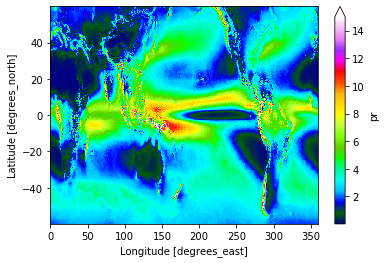

MIROC6


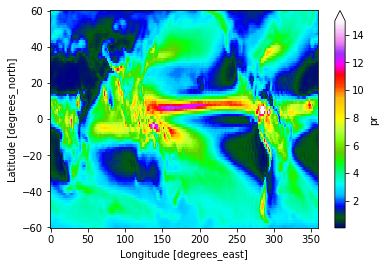

CNRM-ESM2-1


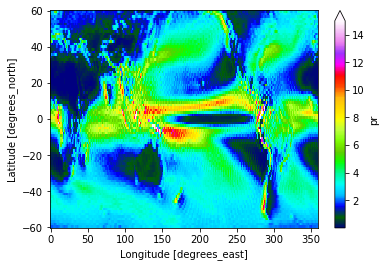

MPI-ESM1-2-HR


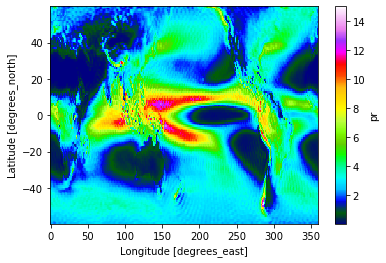

AWI-ESM-1-1-LR


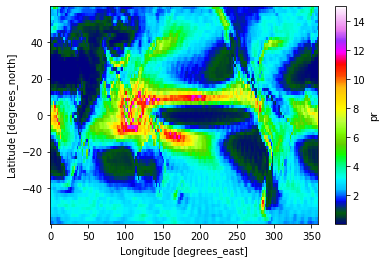

NESM3


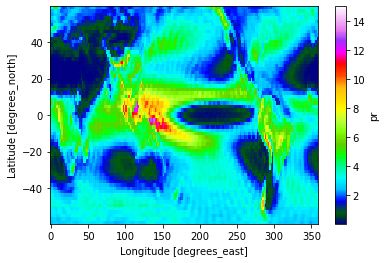

MPI-ESM1-2-LR


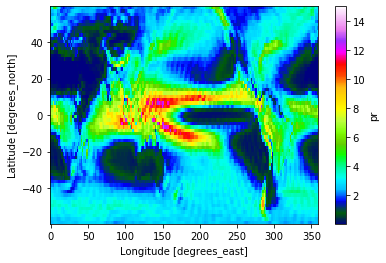

GFDL-CM4


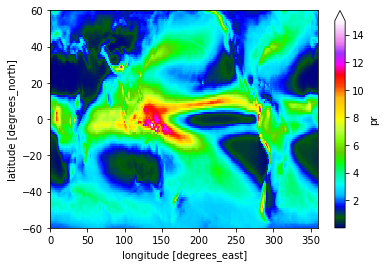

AWI-CM-1-1-MR


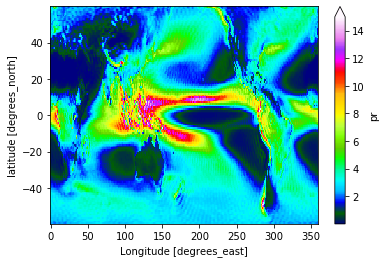

In [42]:

model_folder_names = os.listdir(mean_pr_dir)
for model_index in range(len(model_folder_names)):
    model_file_name = os.listdir(mean_pr_dir + '/' + model_folder_names[model_index])
    
    path_to_file = mean_pr_dir + '/' + model_folder_names[model_index] + '/' + model_file_name[0]
    plt.figure()
    print( model_folder_names[model_index])
    ds_i = xr.open_dataset(path_to_file)
    (FLUX_TO_MM_DAY*ds_i['pr']).plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmax = 15)
    plt.show()

In [26]:

ds_i

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 96, lon: 192)
Coordinates:
  * lat       (lat) float64 -59.38 -58.12 -56.88 -55.62 ... 56.88 58.12 59.38
  * lon       (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 ...
    lon_bnds  (lon, bnds) float64 ...
    pr        (lat, lon) float32 ...

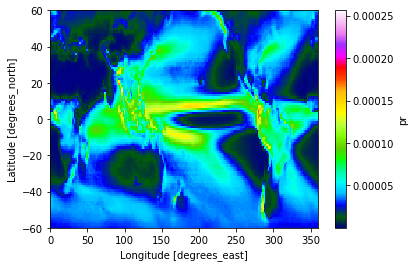

In [56]:
dsds = xr.open_dataset('/export/data1/cchristo/gpm_data/gpmdata_regridded_grid1/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S220000-E222959.1320.V06B.nc')

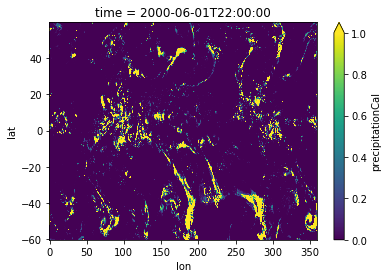

In [57]:
dsds['precipitationCal'].isel(time = 0).plot.imshow(vmax = 1)

In [58]:
dsds

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2000-06-01T22:00:00
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
Data variables:
    precipitationCal  (time, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear